In [1]:
import arcpy,pandas,json
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

## 下面这个方法是用来从matplotlib中的色带获取指定颜色的

In [2]:
def getColorDist(colName, colValue):
    cm = plt.cm.get_cmap(colName)
    colNum = len(colValue)
    col = [cm(float(i)/(colNum)) for i in range(colNum)]
    cols = {}
    for i in range(len(col)):
        c = col[i]
        f = "#"
        for c1 in c:
            cc = "{0}".format(hex(int(c1*255)))[2:]
            if len(cc) < 2:
                cc = "0"+cc
            f+=cc
        cols[colValue[i]] = f
    return cols

In [3]:
cn = "./data/shp/china_simple.shp"

In [4]:
data = pandas.read_csv("./data/旅游收入.csv")

In [37]:
year = "y2016"

## 下面这段代码，是用来计算分位数的

In [38]:
y = data[year].to_numpy()
q25 = numpy.percentile(y, 25)
q50 = numpy.percentile(y, 50)
q75 = numpy.percentile(y, 75)
iqr = q75 - q25
u = q75 + 1.5 * iqr
d = q25 - 1.5 * iqr
if u > max(y):
    u =  max(y)
if d < min(y):
    d = min(y)
box = [d,q25,q50,q75,u]

In [39]:
col = getColorDist("hsv",range(6))
text = {0:" 低异常值",1:" < 25%",2:" 25% - 50%",3:" 50% - 75%",4:" > 75%",5:" 高异常值"}

## 下面是画图用的代码

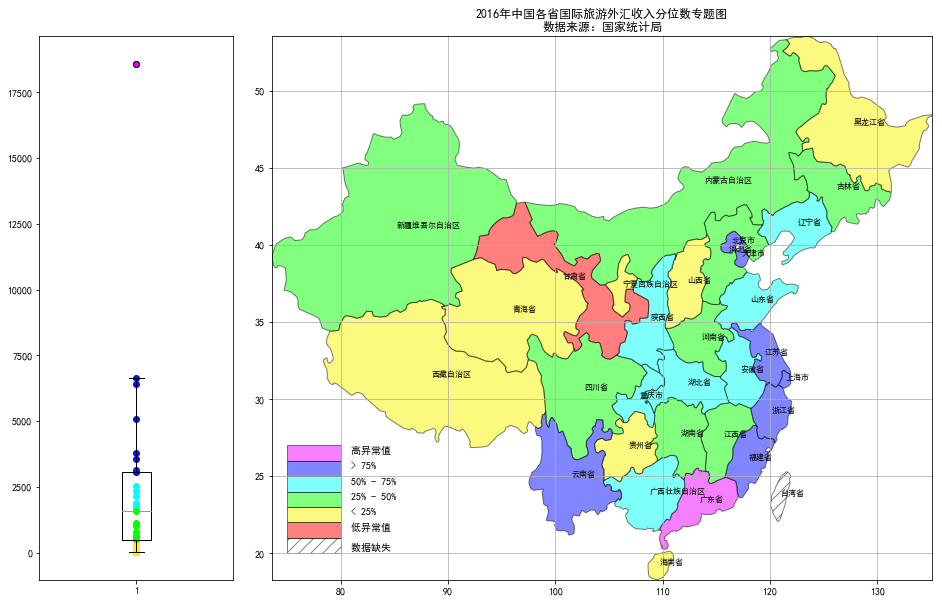

In [40]:
fig = plt.figure(figsize=(16,10)) 
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 1, rowspan = 4)
plt.boxplot(data[year])
ccdict = {}
for i,v in data.iterrows():
    b2 = box+[v[year]]
    b2.sort()
    c = col[b2.index(v[year])]
    ccdict[v["code"]] = c
    plt.scatter(x=1,y=v[year],color=c)

ax2 = plt.subplot2grid((4, 4), (0, 1), colspan = 3, rowspan = 4)
ext = arcpy.Describe(cn).extent
ax2.grid(alpha= 1)
basemap = arcpy.FeatureSet(cn)
for g in arcpy.da.SearchCursor(basemap,["SHAPE@JSON","name",
                                       "SHAPE@XY","code"]):
    if g[3] in ccdict:
        c = ccdict[g[3]]
        poly = plt.Polygon(json.loads(g[0])["rings"][0],
                                ec = '#000000',fc=c, alpha = 0.5)
        if len(json.loads(g[0])["rings"]) > 1:
            poly = plt.Polygon(json.loads(g[0])["rings"][2],
                                ec = '#000000',fc=c, alpha = 0.5)
    else:
        poly = plt.Polygon(json.loads(g[0])["rings"][0],
                                fill=False, hatch='//', alpha = 0.5)
    ax2.text(g[2][0], g[2][1],g[1],fontsize=8)
    ax2.add_patch(poly)

for i in range(len(col)):
    poly = plt.Polygon([[75,22+i],[80,22+i],[80,21+i],[75,21+i],[75,22+i]],
                                ec = '#000000',fc=col[i], alpha = 0.5)
    ax2.text(80.5,21.5+i,text[i],fontsize=10)
    ax2.add_patch(poly)

i=-1
poly = plt.Polygon([[75,22+i],[80,22+i],[80,21+i],[75,21+i],[75,22+i]],
                                fill=False, hatch='//', alpha = 0.5)
ax2.text(80.5,21.2+i," 数据缺失",fontsize=10)
ax2.add_patch(poly)
ax2.set_xlim(ext.XMin,ext.XMax)
ax2.set_ylim(ext.YMin,ext.YMax)
plt.title("{0}年中国各省国际旅游外汇收入分位数专题图\n数据来源：国家统计局".format(year[1:]))
plt.show()